In [1]:
from __future__ import division, print_function
import kf_book.pf_internal as pf_internal
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import uniform
from filterpy.stats import plot_gaussian_pdf
import csv
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import operator
from collections import Counter
import pickle
import math as m

In [2]:
from numpy.random import uniform

def create_uniform_particles(x_range, y_range, hdg_range, N):
    particles = np.empty((N, 3))
    particles[:, 0] = uniform(x_range[0], x_range[1], size=N)
    particles[:, 1] = uniform(y_range[0], y_range[1], size=N)
    particles[:, 2] = uniform(hdg_range[0], hdg_range[1], size=N)
    particles[:, 2] %= 2 * np.pi
    return particles

def create_gaussian_particles(mean, std, N):
    particles = np.empty((N, 3))
    particles[:, 0] = mean[0] + (randn(N) * std[0])
    particles[:, 1] = mean[1] + (randn(N) * std[1])
    particles[:, 2] = mean[2] + (randn(N) * std[2])
    particles[:, 2] %= 2 * np.pi
    return particles

In [3]:
########################
#### Configurations ####
########################

beacons = np.array([[1, 1], [3, 4.9], [1.35, 7.7], [3.3, 10.5], [3.3, 10.5], [6, 0.5], [0.5, 3.3], [6, 10.5]])
NL = len(beacons)

pik = 'SensorModel.dat'

with open(pik, 'rb') as f:
    beacons_mean = pickle.load(f)
    beacons_stds = pickle.load(f)

In [20]:
#######################
##### Update Step #####
#######################

from operator import itemgetter 


def SensorModel(distances):
    m = itemgetter(*distances)(beacons_mean)
    s = itemgetter(*distances)(beacons_stds)
    
    return [m, s]

def update(particles, weights, z, R):
    # print(beacons)
    # print("and then")
    print(particles[:, 0:2])
    # print("and then")
    # print(particles[:, 0:2]/10)
    # print("and then")
    # print(np.max(particles[:, 0:2]))
    # print("and then")
    # print(np.max(particles[:, 0:2]/10))
    for i, beacon in enumerate(beacons):
        distances = np.round((np.linalg.norm(particles[:, 0:2] - beacon, axis=1))/10).astype(int)
        # print(distances)
        ms, ss = SensorModel(distances)
        # print(ms)
        # print(ss)
        
        weights *= scipy.stats.norm(ms, ss).pdf(z[i])

    weights += 1.e-300      # avoid round-off to zero
    weights /= sum(weights) # normalize

In [21]:
#################################
##### State Estimation Step #####
#################################

def estimate(particles, weights):
    """returns mean and variance of the weighted particles"""

    pos = particles[:, 0:2]
    mean = np.average(pos, weights=weights, axis=0)
    var  = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var

In [22]:
#############################
#### Particle Resampling ####
#############################

def simple_resample(particles, weights):
    N = len(particles)
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1. # avoid round-off error
    indexes = np.searchsorted(cumulative_sum, random(N))

    # resample according to indexes
    particles[:] = particles[indexes]
    weights.fill(1.0 / N)
    
def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights[:] = weights[indexes]
    weights.fill(1.0 / len(weights))    

def neff(weights):
    return 1. / np.sum(np.square(weights))

In [23]:
def transition_matrix(transitions, xbins, ybins):
    # states_lookup_table = []
    # for x in range(xbins):
        # for y in range(ybins):
            # states_lookup_table.append("[" + str(x) + ", " + str(y) + "]")

    # n = 1 + len(np.array(list(set(tuple(p) for p in transitions)))) #number of unique states
    M = np.ones((xbins * ybins, xbins * ybins))
    
    for (state, state_p) in zip(transitions,transitions[1:]):
        # print("state is: ")
        # print(state)
        # print("state prime is: ")
        # print(state_p)
        # i = state[0] * (ybins - 1) + state[1]
        # j = state_p[0] * (ybins - 1) + state_p[1]
        
        i = xbins * state[1] + state[0] + 1
        j = xbins * state_p[1] + state_p[0] + 1
        
        # print(i)
        # print(j)
        # i = state[0]*xbins + state[1]
        # j = state_p[0]*xbins + state_p[1]
        # i = states_lookup_table.index(str(state))
        # j = states_lookup_table.index(str(state_p))
        M[i][j] += 1

    #now convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return M

def beacon_sensor_model():
    filename = '../RSSI.csv'

In [24]:
#test:

agenttrace = '../4jul11p.csv'
f = open(agenttrace)
#print(f.readlines)
oracle = []
gridized_data = []

# Information Granularity
                
gridsize = 0.5
realx = 6.6
realy = 10.6
                
xbins = int(np.ceil(realx) / gridsize)
ybins = int(np.ceil(realy) / gridsize)


# print(xbins)
# print(ybins)

with open(agenttrace, 'r') as user_data:
    reader = csv.reader(user_data, delimiter=',', quotechar=',')
    for row in reader:
        if (reader.line_num > 1):
            oracle.append([float(row[4]), float(row[5])])
            
for d in oracle:
    gridized_data.append([int(np.floor(d[0]/gridsize)), int(np.floor(d[1]/gridsize))])        

# print(np.max(gridized_data))

TM = transition_matrix(gridized_data, xbins, ybins)

# print(len(TM[:,1]))
# print(len(TM[1,:]))

# for row in m: 
#     print(' '.join('{0:.2f}'.format(x) for x in row))

In [25]:
with open(agenttrace, 'r') as user_data:
    reader = csv.reader(user_data, delimiter=',', quotechar=',')
    for row in reader:
        if (reader.line_num > 1):
            oracle.append([float(row[4]), float(row[5])])
            
for d in oracle:
    gridized_data.append([int(np.floor(d[0]/gridsize)), int(np.floor(d[1]/gridsize))])        

In [26]:
def CumulativeSum(m):
    return m.cumsum()

def returnobj(cdf):
    # print("aaaaaaaaaaaabbbbbbb:")
    # print(cdf)
    randnum = np.random.random()
    for i in range(len(cdf) - 1):
        if((randnum>cdf[i]) and (randnum<=cdf[i + 1])):
            return i

def IndexToState(index, xbins, ybins):
    # print("aaaaaa:")
    # print(index)
    x = np.floor(index/(ybins + 1))
    y = index % (ybins + 1)
    return x, y

def StateToIndex(x, y, xbins, ybins):
    i = xbins * np.floor(y) + np.floor(x)
    # print("aaaa")
    # print(x)
    # print(y)
    # print(i)
    return int(i)
    
    # return int((ybins + 1) * np.floor(x) + np.floor(y))
        
def NextStates(TM, particles, xbins, ybins):
    cdf = np.apply_along_axis(CumulativeSum, 1, TM)
    zero = np.array([0]) # np.zeros((len(cdf[:,1]))
    
    c = np.tile(zero[np.newaxis,:], (cdf.shape[0],1))
    cdf = np.concatenate((c, cdf), axis=1)
    
    # cdf = np.concatenate([np.zeros((len(cdf[:,1])), 1), cdf])
    # next_states = []
    #print(len(particles))
    next_states = np.empty((len(particles), 2))
    
    for i in range(len(particles)):
        current_state_x = particles[i, 0]
        current_state_y = particles[i, 1]
        
        row = StateToIndex(current_state_x, current_state_y, xbins, ybins)
        # print(row)
        next_state_index = returnobj(cdf[row])
        next_states[i, 0] = IndexToState(next_state_index, xbins, ybins)[0]
        next_states[i, 1] = IndexToState(next_state_index, xbins, ybins)[1]
    
    # for (state, state_p) in zip(transitions,transitions[1:]):
        # i = state[0]*xbins + state[1]
        # j = state_p[0]*xbins + state_p[1]
    
    # print(len(next_states))
    # print(next_states[:,0])
    return next_states

In [27]:
########################
##### Predict Step #####
########################

def predict(particles, xbins, ybins):
    next_states = NextStates(TM, particles, xbins, ybins)
    particles[:, 0] += next_states[:, 0]
    particles[:, 1] += next_states[:, 1]
    
    return particles

In [28]:
from filterpy.monte_carlo import systematic_resample
from numpy.linalg import norm
from numpy.random import randn
import scipy.stats

def DistanceToRSSI(agent_pos):
    rssi_values = []
    for b in beacons:
        dist = int(round(np.linalg.norm(b - agent_pos)))
        
        # Max reading is 7 meters
        if (dist > 7):
            dist = 7
        
        # print(dist)
        mean = beacons_mean[dist - 1]
        std = beacons_stds[dist - 1]
        
        sample = np.random.normal(mean, std, 1)
        rssi_values.append(sample[0])
        
    return rssi_values

def run_pf1(N, iters=18, sensor_std_err=.1, do_plot=True, plot_particles=False, xlim=(0, 20), ylim=(0, 20), initial_x=None):
    plt.figure()
   
    # create particles and weights
    particles = create_uniform_particles((0,xbins), (0,ybins), (0, 6.28), N)    
    weights = np.ones(N) / N

    if plot_particles:
        alpha = .20
        if N > 5000:
            alpha *= np.sqrt(5000)/np.sqrt(N)           
        plt.scatter(particles[:, 0], particles[:, 1], alpha=alpha, color='g')
    
    xs = []
    robot_pos = np.array([0., 0.])
    step = 1
    for gt in range(len(oracle)):
        print(step)
        step = step + 1
        # Agent's current location
        agent_pos = oracle[gt]
        # print("aaaa")
        # print(agent_pos)
        # move particles based on transition matrix
        # predict(particles, u=(0.00, 1.414), std=(.2, .05))
        particles = predict(particles, xbins, ybins)
        
        # Observation from Beacons' RSSI
        zs =  DistanceToRSSI(agent_pos)
        
        # Weighting particles based on our observation 
        update(particles, weights, z = zs, R = sensor_std_err)
        
        
    
        
        # resample if too few effective particles
        if neff(weights) < N/2:
            indexes = systematic_resample(weights)
            resample_from_index(particles, weights, indexes)
            assert np.allclose(weights, 1/N)
        mu, var = estimate(particles, weights)
        xs.append(mu)

        if plot_particles:
            plt.scatter(particles[:, 0], particles[:, 1], color='k', marker=',', s=1)
        
        p1 = plt.scatter(robot_pos[0], robot_pos[1], marker='+', color='k', s=180, lw=3)
        p2 = plt.scatter(mu[0], mu[1], marker='s', color='r')
    
    xs = np.array(xs)
    #plt.plot(xs[:, 0], xs[:, 1])
    plt.legend([p1, p2], ['Actual', 'PF'], loc=4, numpoints=1)
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    print('final position error, variance:\n\t', mu - np.array([iters, iters]), var)
    plt.show()

1
[[11.10392863 28.99864142]
 [ 6.36296725 35.76995214]
 [19.69527469 15.70665887]
 ...
 [ 9.22641522 18.1518749 ]
 [12.93043748 32.00959008]
 [ 5.4071312  15.81201323]]
2


IndexError: index 496 is out of bounds for axis 0 with size 308

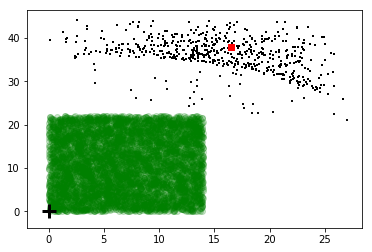

In [29]:
from numpy.random import seed
seed(2) 
run_pf1(N=5000, plot_particles=True)

In [ ]:
len(cdf)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Our 2-dimensional distribution will be over variables X and Y
N = 100
X = np.linspace(49, 51, N)
Y = np.linspace(49, 51, N)
X, Y = np.meshgrid(X, Y)

# Mean vector and covariance matrix
mu = np.array([50., 50.])
Sigma = np.array([[ 0.2 , 0.], [0.,  0.2]])

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.

    """

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

# The distribution on the variables X, Y packed into pos.
Z = multivariate_gaussian(pos, mu, Sigma)
grid = Z
# Create a surface plot and projected filled contour plot under it.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True, cmap=cm.viridis)

# cset = ax.contourf(X, Y, Z, zdir='z', offset=-0.15, cmap=cm.viridis)

# Adjust the limits, ticks and view angle
# ax.set_zlim(-0.15,0.2)
# ax.set_zticks(np.linspace(0,0.2,5))
ax.view_init(30, 50)

plt.show()

import pylab as pl
from matplotlib.colors import LogNorm
from matplotlib.colors import PowerNorm

# im = plt.matshow(zip(*error_heatmap_averaged), cmap=pl.cm.RdYlGn_r)
im = plt.matshow(grid, cmap=pl.cm.OrRd)

plt.colorbar(im)
plt.show()

In [ ]:
import pylab as pl
from matplotlib.colors import LogNorm
from matplotlib.colors import PowerNorm

# im = plt.matshow(zip(*error_heatmap_averaged), cmap=pl.cm.RdYlGn_r)
im = plt.matshow(grid, cmap=pl.cm.OrRd)

plt.colorbar(im)
plt.show()

In [ ]:
grid

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as sp

x = np.random.randn(100000)
y = np.random.randn(100000)


X = sp.filters.gaussian_filter(x, sigma = 2, order = 0)
Y = sp.filters.gaussian_filter(y, sigma = 2, order = 0)

# normal distribution center at x=0 and y=5
fig1 = plt.subplot(2,2,1)
plt.hist2d(x, y, bins=40)
plt.colorbar()
plt.title('Heatmap without smoothing')
plt.xlabel("X")
plt.ylabel("Y")

In [ ]:
# Add a colorbar if necessary
plt.hexbin(x, y, gridsize=(25,25), cmap=plt.cm.Purples_r)

plt.show()
